## Output figure of select compound distributions in LINCS data

In [1]:
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(patchwork))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "lincs_distribution_raw")
extensions <- c(".png", ".pdf")

In [3]:
# Compounds of interest
# Taken from 1.find_representative_images.ipynb
select_compounds <- list(
    c("kpt-330", "3.33 uM"),
    c("resminostat", "10 uM"),
    c("amlodipine", "0.37 uM"),
    c("fluphenazine", "0.04 uM"),
    c("DMSO", "-666")
)

select_compounds

[[1]]
[1] "kpt-330" "3.33 uM"

[[2]]
[1] "resminostat" "10 uM"      

[[3]]
[1] "amlodipine" "0.37 uM"   

[[4]]
[1] "fluphenazine" "0.04 uM"     

[[5]]
[1] "DMSO" "-666"

In [4]:
# Load L1000 readouts
input_dir <- file.path("..", "1.Data-exploration", "Profiles_level4", "L1000", "L1000_lvl4_cpd_replicate_datasets")
l1000_file <- file.path(input_dir, "L1000_level4_cpd_replicates.csv.gz")

l1000_col_types <- readr::cols(
  .default = readr::col_double(),
  replicate_id = readr::col_character(),
  sig_id = readr::col_character(),
  pert_id = readr::col_character(),
  pert_idose = readr::col_character(),
  det_plate = readr::col_character(),
  det_well = readr::col_character(),
  Metadata_broad_sample = readr::col_character(),
  pert_iname = readr::col_character(),
  moa = readr::col_character()
)

df <- readr::read_csv(l1000_file, col_types = l1000_col_types)

print(dim(df))
head(df)

[1] 27837   988


replicate_id,200814_at,222103_at,201453_x_at,204131_s_at,200059_s_at,205067_at,213702_x_at,214435_x_at,201334_s_at,⋯,205379_at,sig_id,pert_id,pert_idose,det_plate,det_well,dose,Metadata_broad_sample,pert_iname,moa
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
REP.A001_A549_24H_X1_B27:A03,0.3547,-0.4940,-0.1721,-0.0339,-0.4355,1.8263,-0.1316,0.0853,-0.4660,⋯,0.1046,REP.A001_A549_24H:A03,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A03,0,DMSO,DMSO,Control vehicle
REP.A001_A549_24H_X2_B27:A03,-0.0447,-1.6390,-0.5276,-0.5092,-0.5733,0.2445,0.6159,-1.1273,2.8250,⋯,-1.5836,REP.A001_A549_24H:A03,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A03,0,DMSO,DMSO,Control vehicle
REP.A001_A549_24H_X3_B27:A03,-0.9583,0.2657,-0.8204,-0.5851,-2.0808,0.0739,-0.0497,-0.3012,-0.9787,⋯,-0.1416,REP.A001_A549_24H:A03,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A03,0,DMSO,DMSO,Control vehicle
REP.A001_A549_24H_X1_B27:A04,-0.2130,0.4931,-0.8768,-0.6968,-1.7018,-0.3779,-0.6745,-1.9799,-1.1429,⋯,-1.8243,REP.A001_A549_24H:A04,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A04,0,DMSO,DMSO,Control vehicle
REP.A001_A549_24H_X2_B27:A04,0.7499,-1.2819,0.4981,1.7090,1.6765,-1.2690,1.7974,-1.2213,3.4625,⋯,0.3157,REP.A001_A549_24H:A04,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A04,0,DMSO,DMSO,Control vehicle
REP.A001_A549_24H_X3_B27:A04,-0.3717,-0.8372,0.2371,-0.9938,0.0000,-0.4764,-2.0125,0.2586,1.3823,⋯,0.5455,REP.A001_A549_24H:A04,DMSO,-666,REP.A001_A549_24H_X1_B27|REP.A001_A549_24H_X2_B27|REP.A001_A549_24H_X3_B27,A04,0,DMSO,DMSO,Control vehicle


In [5]:
l1000_ggs <- list()
for (cpd_info in select_compounds) {
    cpd <- cpd_info[1]
    dose <- cpd_info[2]
    
    # Process compound data for plotting input
    df_subset <- df %>%
        dplyr::filter(pert_iname == !!cpd, pert_idose == !!dose) %>%
        dplyr::select(replicate_id, dplyr::ends_with("at"))
    
    if (cpd == "DMSO") {
        df_subset <- df_subset %>% dplyr::sample_n(5)
    }
    df_melted_subset <- df_subset %>%
        reshape2::melt(id = "replicate_id", variable.name = "probe", value.name = "gene_exprs") %>%
        dplyr::group_by(probe) %>%
        dplyr::mutate(probe_sum = sum(gene_exprs)) %>%
        dplyr::arrange(desc(probe_sum)) %>%
        dplyr::ungroup() %>%
        dplyr::group_by(replicate_id)
    
    if (cpd == "DMSO") {
        df_melted_subset <- df_melted_subset %>%
            dplyr::mutate(
                x_axis_dummy = row_number(),
                replicate_truncated = substring(replicate_id, 19, 28)
            )
        fig_title <- cpd
    } else {
        df_melted_subset <- df_melted_subset %>%
            dplyr::mutate(
                x_axis_dummy = row_number(),
                replicate_truncated = substring(replicate_id, 19, 20)
            )
        fig_title <- paste0(cpd, " (", dose, ")")
    }
        
    # Save figure in a list
    l1000_ggs[[cpd]] <- (
        ggplot(df_melted_subset, aes(x = x_axis_dummy, y = gene_exprs, color = replicate_truncated))
        + geom_point(alpha = 0.3)
        + geom_smooth(aes(group = replicate_truncated), color = "black", se = FALSE, method = "loess", span = 0.02, formula = 'y ~ x', lwd = 1.5)
        + geom_smooth(se = FALSE, method = "loess", span = 0.02, formula = 'y ~ x', lwd = 1)
        + figure_theme
        + ggtitle(fig_title)
        + ylab("L1000 expression")
        + xlab("Probe index (sorted)")
        + scale_color_discrete(name = "Replicate")
    )
}

In [6]:
panel_a_gg <- l1000_ggs[["kpt-330"]]
panel_b_gg <- l1000_ggs[["resminostat"]]
panel_c_gg <- l1000_ggs[["amlodipine"]]
panel_d_gg <- l1000_ggs[["fluphenazine"]]
panel_e_gg <- l1000_ggs[["DMSO"]]

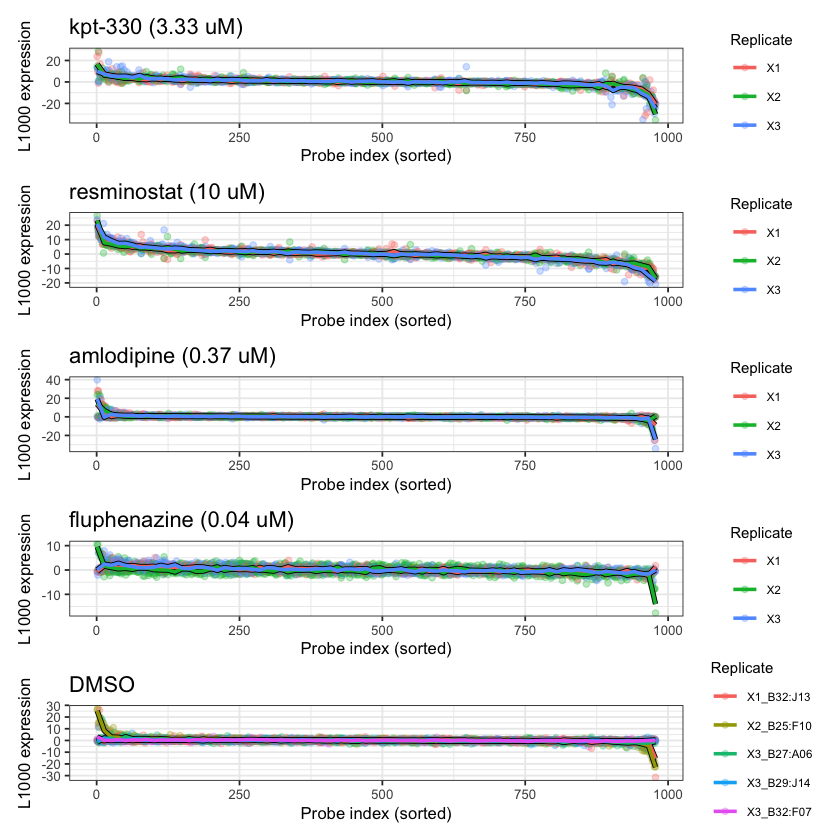

In [7]:
lincs_distrib_gg <- (
    panel_a_gg /
    panel_b_gg /
    panel_c_gg /
    panel_d_gg /
    panel_e_gg
)

lincs_distrib_gg

In [8]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    ggplot2::ggsave(output_file, lincs_distrib_gg, height = 12, width = 8, dpi = 500)
}